In [1]:
import numpy as np
import pandas as pd

import numpy as np
from pandas.tseries.offsets import BDay
import math
import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [2]:
from hurst import compute_Hc, random_walk

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from hurst import compute_Hc, random_walk

In [4]:
def ShannonFast(df):
    df=df[df!=0.0]
    shift_returns = df.shift(1)
    shift_returns2 = df.shift(2)
    shift_returns3 = df.shift(3)
    
    #df['test']  = np.sign(df['returns']).astype('str').dropna() + np.sign(df['shift_returns2']).astype('str').dropna() +  np.sign(df['shift_returns3']).dropna().astype('str')
    
    df =df.dropna(axis=0)
    
    Pattern  = np.sign(df.dropna()).astype('str') + np.sign(shift_returns2.dropna()).astype('str') +  np.sign(shift_returns3.dropna()).astype('str')
    
    Pattern=Pattern.dropna().str.replace('.0','')
    patternList = Pattern.dropna().str.replace('.0','').unique().tolist()
    total = 0.0
    ShannonPatterns = {}
    
    for e in patternList:
        ShannonPatterns[e] = 0

    for pattern in ShannonPatterns.keys():        
        value = (len(np.where(Pattern==pattern)[0]))
        ShannonPatterns[pattern] +=  value
        total += value
        
    
    ProbSum = 0.0
    for pattern in ShannonPatterns.keys():
        p = ShannonPatterns[pattern] / total        
        value = p * np.log2(p)        
        if math.isnan(value):
            continue
        ProbSum = ProbSum + value
    Shannon_val = -ProbSum
    return Shannon_val

def Shannon(df, patternSize):
    
    chunks = []
    for i in range(0, len(df)):
        chunks.append(df[i:i+patternSize])
    
    chunks = chunks[:-patternSize-1]
    
    
    chunks = [np.array2string(x) for x in chunks.copy()]
    
    
    
    
    chunks_set = list(set(chunks))
    
    
    visited = {}
    total = 0
    for el in chunks_set:
        if (el not in visited):
            f = chunks.count(el)
            visited[el] = f
            total = total + f
    ProbSum = 0.0
    for el in visited:
        p = visited[el]/total
        value = p * np.log2(p)
        #visited[el] = value
        ProbSum = ProbSum + value
    Shannon_val = -ProbSum
    del visited, chunks
    
    
    
    return Shannon_val

def marketMeannes(df):
    
    m = np.median(df) 
    nh = 0
    nl = 0
    
    for i in range(1, len(df)-1):
        Pt = df[i]
        Py = df[i-1]
        
        if (Py > m) & (Py > Pt):
            nl += 1
        elif (Py < m) & (Py < Pt):
            nh += 1
        else:
            None
    return (nl+nh)/(len(df)-1)
        
    
    
def Momersion(df):
    #print(np.where(df == 1)[0])
    #df = df['returns'].copy() * df['returns'].shift(1)
    df = df.copy() * df.shift(1)
    
    df = df.dropna()
    df = np.sign(df)
    pos = len(np.where(df == 1)[0])
    neg = len(np.where(df == -1)[0])
    #zero = len(np.where(df == 0.0)[0])
    if (pos + neg) == 0.0:
        return -1.0
    #print(pos, neg)
    mom = (pos / (pos+neg )) #*100.0
    return mom
# https://pypi.org/project/hurst/
def hurst(ts):
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # plot on log-log scale
    #plt.plot(np.log(lags), np.log(tau)); plt.show()
    # calculate Hurst as slope of log-log plot
    #print(lags, tau)
    m = np.polyfit(np.log(lags), np.log(tau), 1)

 
    hurst = m[0]*2.0
    #print ('hurst = ',hurst)
    #plt.clf(), plt.close()
    return hurst

def MomersionDouble(df):

    df = df[df!=0.0]
    shift_returns = df.shift(1).fillna(0)
    shift_returns2 = df.shift(2).fillna(0)
    shift_returns3 = df.shift(3).fillna(0)
    Pattern = np.sign(shift_returns * shift_returns2)
    Pattern2= np.sign(shift_returns2 * shift_returns3)
    df = df.dropna()

    pp = len(np.where( (Pattern == 1 ) & (Pattern2 == 1 ) )[0])
    pm = len(np.where( (Pattern == 1 ) & (Pattern2 == -1 ) )[0])
    mp = len(np.where( (Pattern == -1 ) & (Pattern2 == 1 ) )[0])
    mm = len(np.where( (Pattern == -1 ) & (Pattern2 == -1 ) )[0])

    total = (pp+pm-mp-mm)/(df.count()-1.0)
    #threshUp = total>=np.sqrt(len(df))

    return total #(total, len(df), np.sqrt(len(df)))

def proportion(df):
    pp = len(np.where( (df >0.0  ) )[0])
    mm = len(np.where( (df < 0.0 ) )[0])
    
    if mm == 0.0 or mm is None:
        mm = 1
    return pp/mm
    
def proportionPos(df):
    pp = len(np.where( (df >0.0  ) )[0])
    mm = len(np.where( (df < 0.0 ) )[0])
    
    if mm == 0.0 or mm is None:
        mm = 1
    return 100.0 * pp/(pp+mm) 

def autoCorrel(df, lag):
    return pd.Series.autocorr(df, lag)


def hurstF(ts):
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # plot on log-log scale
    #plt.plot(np.log(lags), np.log(tau)); plt.show()
    # calculate Hurst as slope of log-log plot
    #print(lags, tau)
    m = np.polyfit(np.log(lags), np.log(tau), 1)

 
    hurst = m[0]*2.0
    #print ('hurst = ',hurst)
    #plt.clf(), plt.close()
    return hurst


def hurstF2(p):
    lags = range(2,100)


    variancetau = []; tau = []

    for lag in lags: 

        #  Write the different lags into a vector to compute a set of tau or lags
        tau.append(lag)

        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = np.subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    #print tau
    #print variancetau

    # plot the log of those variance against the log of tau and get the slope
    m = np.polyfit(np.log10(tau),np.log10(variancetau),1)

    hurst = m[0] / 2

    return hurst

def hurstF3(series):
   

    #H, c, data = compute_Hc(series.replace([np.inf, -np.inf], np.na).dropna(), kind='price', simplified=True)
    H, c, data = compute_Hc(series.replace([np.inf, -np.inf], np.nan).dropna(), kind='random_walk', simplified=False)
    return H

def hurstF4(series):
   
    
    H, c, data = compute_Hc(series, kind='random_walk', simplified=True)
    return H



In [41]:
def generateRWI2(df):
    MomVal = Momersion(df[['returns']]) 
    MomDouble = MomersionDouble(df['returns'])
 
    h1 =  hurstF(df['price'])
    h2 =  hurstF2(df['price'])
    h3 =  hurstF3(df['price'])

    h4 = hurstF4(df['price'])
   
  
    #df = df.copy().join(autoCorr_features(df[['returns']].copy()), rsuffix='_suka_')
    
    MMIR = marketMeannes(df['returns'])
    
    MMIP = marketMeannes(df['price'])
    ShannonVal = ShannonFast(df['returns'])
    prop = proportionPos(df['returns'])
    correl_1 = autoCorrel(df.returns, 1)
    correl_2 = autoCorrel(df.returns, 2)
    correl_3 = autoCorrel(df.returns, 3)
    correl_4 = autoCorrel(df.returns, 4)
    correl_5 = autoCorrel(df.returns, 5)
    correl_10 = autoCorrel(df.returns, 10)
    correl_20 = autoCorrel(df.returns, 20)
    correl_100 = autoCorrel(df.returns, 100)
    correl_list = [correl_1, correl_2, correl_3, correl_4, correl_5, correl_10, correl_20, correl_100]
    
    var_std = df['returns'].std()
    var_mean = df['returns'].mean()
    var_median = df['returns'].mean()
    
    
    return [MomVal, MomDouble, h1, h2, h3, h4, MMIR, MMIP, ShannonVal, prop, var_std, var_mean, var_median] + correl_list

In [43]:
def generate_features(df):
    df.columns = ['price']
    
    df['returns'] = np.log(df['price']/df['price'].shift(1))
    
    df['ROC_2'] =  np.log(df['price'].copy()).pct_change(2)
    
    df['ROC_3'] = np.log(df['price'].copy()).pct_change(3)
    df['ROC_5'] = np.log(df['price'].copy()).pct_change(5)
    df['ROC_20'] = np.log(df['price'].copy()).pct_change(20)
    df['ROC_50'] = np.log(df['price'].copy()).pct_change(50)
    df['ROC_100'] = np.log(df['price'].copy()).pct_change(100)
    #df['ROC_200'] = np.log(df['price'].copy()).pct_change(200)
    #df['ROC_300'] = np.log(df['price'].copy()).pct_change(300)
    #df['ROC_500'] = np.log(df['price'].copy()).pct_change(500)
    
    
    df['abs_returns'] =  np.log(np.abs(df['price'].copy())).pct_change()
    

    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    return df

In [44]:
lookup = [1, 1,  2, 2, 3, 4, 5, 10, 20,  50 , 100, 200, 300]

In [45]:
proba = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]

In [55]:
results = []
for i in range(0, 100):
    print(i)
    for lk in lookup:
        for prob in proba:
            tmp = random_walk(1500,proba=prob,  min_lookback=lk, max_lookback=lk) #np.random.uniform(0.61, 0.90,1)
            tmp = [e[0] if (type(e)==np.ndarray) else e for e in tmp.copy()]
            df = pd.DataFrame(np.asarray(tmp)+100)
            scaler = MinMaxScaler(feature_range=(0.0, 1.0))
            df_ = scaler.fit_transform(df)
            df_ = pd.DataFrame(df_, columns=df.columns,index=df.index)
            df = (1+df_)
            res = generate_features(df)
            df = df.replace([np.inf, -np.inf],0).fillna(0)

            df['shift_returns'] = df['returns'].shift(-1).dropna()
            df = df[df.shift_returns != 0.0].dropna()
            y = df.iloc[:, [-1]]
            y.shift_returns = np.sign(y.shift_returns)
            X = df.iloc[:, 0:7]
            
            rwi_list = generateRWI2(df)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
            
            clf = RandomForestClassifier(n_estimators=100, max_depth=5,
                                         random_state=0)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            score = accuracy_score(y_test, y_pred)
            rwi_list.append(prob)
            rwi_list.append(lk)
            rwi_list.append(score)
            results.append(rwi_list)
        
            
        
            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [526]:
cols = ['MomVal', 'MomDouble', 'h1', 'h2', 'h3', 'h4', 'MMIR', 'MMIP', 'ShannonVal', 'prop', 'var_std', 'var_mean', 'var_median',   'correl_1', 'correl_2', 'correl_3', 'correl_4', 'correl_5', 'correl_10', 'correl_20', 'correl_100' ,  'prob', 'lk', 'score']

In [527]:
accuracy_df = pd.DataFrame(results, columns=cols) #.corr(method='spearman')['score'].sort_values()

In [528]:
#accuracy_df.corr(method='spearman')['lk'].sort_values()

In [529]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [530]:
from sklearn.preprocessing import StandardScaler

In [531]:
scaler = StandardScaler()

In [532]:
norm_df = pd.DataFrame(scaler.fit_transform(accuracy_df), index=accuracy_df.index, columns=accuracy_df.columns)

In [533]:
norm_df.drop(columns=['ShannonVal', 'prob', 'lk'], inplace=True)

In [534]:
norm_df.columns

Index(['MomVal', 'MomDouble', 'h1', 'h2', 'h3', 'h4', 'MMIR', 'MMIP', 'prop',
       'var_std', 'var_mean', 'var_median', 'correl_1', 'correl_2', 'correl_3',
       'correl_4', 'correl_5', 'correl_10', 'correl_20', 'correl_100',
       'score'],
      dtype='object')

In [535]:
cols_auto= [ 'MomVal', 'MomDouble', 'correl_1', 'correl_2', 'correl_3', 'correl_4', 'correl_5', 'correl_10', 'correl_20', 'correl_100' ,
       'score']

In [536]:
norm_df = norm_df[cols_auto]

In [537]:
X = norm_df.drop(columns='score')

In [538]:
y = norm_df['score']

In [539]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [540]:
reg = Lasso(alpha=0.001).fit(X_train, y_train)

In [541]:
reg.score(X_test, y_test)

0.559671732383555

In [542]:
cols2 = ['MomVal',
 'MomDouble',
 'h1',
 'h2',
 'h3',
 'h4',
 'MMIR',
 'MMIP',

 'prop',
 'var_std',
 'var_mean',
 'var_median',
 'correl_1',
 'correl_2',
 'correl_3',
 'correl_4',
 'correl_5',
 'correl_10',
 'correl_20',
 'correl_100']

In [543]:
pd.DataFrame(reg.coef_, index=cols_auto[:-1]).sort_values(by=0)

,0
correl_1,-1.561392
correl_20,-0.036866
correl_100,-0.034198
correl_5,-0.033787
correl_10,-0.026549
MomDouble,0.000202
correl_3,0.224652
correl_2,0.262525
correl_4,0.488150
MomVal,1.316105


In [544]:
from sklearn.tree import DecisionTreeRegressor

In [545]:
reg_tree = DecisionTreeRegressor(max_depth=10)
reg_tree.fit(X_train, y_train)
y_pred = reg_tree.predict(X_test)

reg_tree.score(X_test, y_test)


0.8576493460247853

In [546]:
pd.DataFrame(reg_tree.feature_importances_, index=cols_auto[:-1]).sort_values(by=0)

,0
correl_100,0.005797
correl_20,0.007343
correl_10,0.011251
correl_4,0.022501
correl_2,0.024531
correl_3,0.033180
correl_5,0.055244
MomDouble,0.099946
correl_1,0.342584
MomVal,0.397622


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


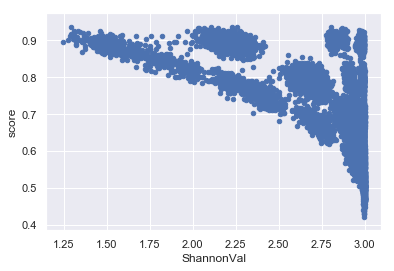

In [484]:
pd.DataFrame(results, columns = cols)[['ShannonVal', 'score']].plot.scatter(x='ShannonVal', y='score')

In [32]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df.price.pct_change().plot()

In [ ]:
# features:
# h1, h2, h3, h4 ,h5
#mom, mom doub,e MMI, Shannon,
# lookup, proportion, accuracy

In [ ]:
## what else to-do?
### correlations and import fatures with scores
# predict accuracy

# accuracy but time test-split


# other ideas. Imported momentum indicators. And remov them
# rolling regression and accuracy as an indicator for predictability
# combine multiple states. trend, random, mean-reversal. Implement indicator for detection states. Implement robust ML algo. Or HMM state detection

# aggregate into higher tf

# test with korean stocks:
# accuracy relations and prediction, state detection
# predict accuracy of the sample TS
